# LLM - Claude - Antrhopic

El objetivo de este Notebook es realizar la evaluación de diferentes modelos de OpenAI para clasificar el texto en emociones. Se utilizan diferentes métodos de transfer learning con el fin de encontrar el mejor modelo.

## Libraries

In [38]:
import json
import os
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv
import anthropic
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

## Dataset

Se cargan los datasets de `training`, `validation` y `test` que se han utilizado en otros modelos para garantizar consistencia al momento de comparar los resultados. Cada uno de estos datasets contiene dos variables **text** y **emotion**

In [2]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv")
df_val = pd.read_csv("../data/data_to_model/val_data.csv")
df_test = pd.read_csv("../data/data_to_model/test_data.csv")

In [3]:
df_train.head()

,text,emotion
0,when the week for exams came i got afraid as t...,fear
1,i was sleeping when i heard the neighbours scr...,fear
2,there was a time when my room looked terribly ...,shame
3,when my friend told me that he would come and ...,joy
4,"when i saw the film ""johnny got his gun"" which...",sadness


## Anthropic Client Configuration

En este paso se configura el cliente con el API Key previamente generada en https://console.anthropic.com/settings/keys

Es importante mencionar que el uso de esta API consume créditos (dinero), por lo tanto, no se hace pública y para reproducir el Notebook deben configurar su propia API Key en el archivo `.env` con el siguiente formato:

ATHROPIC_API_KEY = sk-xxxxxxxxx

In [16]:
load_dotenv()

True

In [28]:
# Testing conection and response

client = anthropic.Anthropic(
    api_key=os.getenv("ATROPIC_API_KEY"),
)
message = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1024,
    temperature=0,
    messages=[{"role": "user", "content": "Say Hello"}],
)
print(message.content[0].text)

Hello!


## Transfer Learning

Los LLM han sido entrenados con enormes volumenes de datos y han guardado en sus parametros todo lo aprendido en este proceso. El proceso de Transfer Learning consiste en utilizar dichos modelos pre entrenados con sus parámetros para tareas específicas sin realizar entrenamientos adicionales.

En este caso solo se utiliza el conjunto de datos de pruebas para poder comparar las métricas con el método de fine-tuning

### Avalible models

Al momento de este desarrollo, los modelos disponibles de Antrhopic para utilizar en la API son los siguientes
* `claude-3-5-sonnet-20240620`
* `claude-3-opus-20240229`
* `claude-3-sonnet-20240229`
* `claude-3-haiku-20240307` 

## `claude-3-haiku-20240307` Model

In [31]:
df_test.head(3)

,text,emotion
0,when a friend carelessly broke and object in m...,anger
1,when i felt powerless to help the poor or when...,sadness
2,one of my best friends'fianct broke off the re...,shame


In [43]:
# System message defining the role and task for the model
system_message = """
You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
[shame, sadness, joy, guilt, fear, disgust, anger].

**Important Rules:**
1. You must return only **one** of the emotions from the list without additional text.
2. Do **not** create or infer any emotions outside the list.
3. If the text does not match any emotion exactly, return the closest emotion from the list. 
4. Do **not** return 'None', 'jealousy', or any other emotion that is not in the list.
5. Do not return additional text, only **exactly one emotion** of the list.

Your answer can only be shame, sadness, joy, guilt, fear, disgust, or anger.
If you're unsure, assign the closest emotion from the allowed list.


For example:

Text: when the week for exams came I got afraid as to how I would tackle the questions.
Response: fear
"""

MODEL = "claude-3-haiku-20240307"


# Function to create the user message (prompt) for emotion detection
def create_user_message(row):
    return f"{row['text']}"


# Initialize an empty column to store the predictions
df_test["predicted_emotion"] = (
    None  # Create a new column for storing the predicted emotions
)

# Iterate over each row in df_test
for index, row in df_test.iterrows():
    test_messages = []
    user_message = create_user_message(row)
    test_messages.append({"role": "user", "content": user_message})

    # Call the Claude model for emotion classification with the system parameter
    response = client.messages.create(
        model=MODEL,
        max_tokens=7,
        temperature=0,
        system=system_message,  # Correctly passing the system message
        messages=test_messages,  # Using the user input as the main prompt
    )

    # Extract the model's response (predicted emotion)
    predicted_emotion = response.content[0].text.strip()

    # Store the predicted emotion in the new column
    df_test.at[index, "predicted_emotion"] = predicted_emotion

# Display the dataframe with the predicted emotions
df_test.head()

,text,emotion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,guilt
1,when i felt powerless to help the poor or when...,sadness,sadness
2,one of my best friends'fianct broke off the re...,shame,shame
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


Classification Report:
              precision    recall  f1-score   support

       anger       0.58      0.57      0.58       109
     sadness       0.74      0.56      0.64       107
       shame       0.75      0.76      0.76       109
       guilt       0.58      0.58      0.58       106
     disgust       0.94      0.89      0.92       109
        fear       0.47      0.88      0.61       108
         joy       0.85      0.37      0.51       106

    accuracy                           0.66       754
   macro avg       0.70      0.66      0.66       754
weighted avg       0.70      0.66      0.66       754



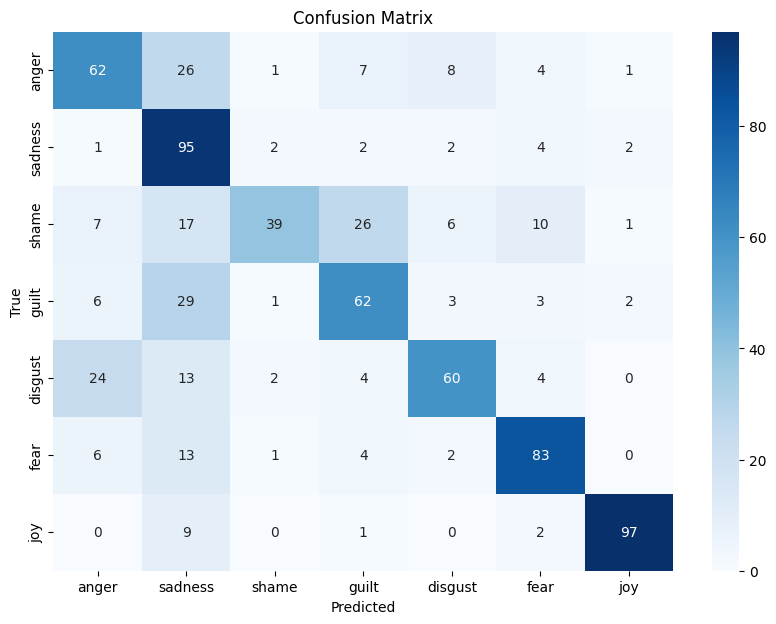

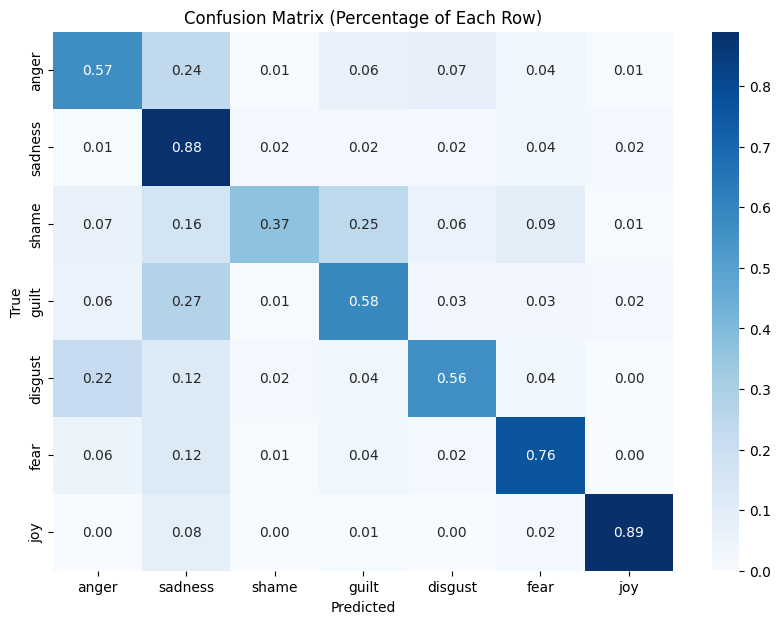

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,claude-3-haiku-20240307,Transfer Learning,0.660477,0.703567,0.659056,0.657013


In [52]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": "claude-3-haiku-20240307",
        "Method": "Transfer Learning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df_tl = pd.DataFrame(results)


# Step 2: Confusion matrix
conf_matrix = confusion_matrix(
    df_test["emotion"],
    df_test["predicted_emotion"],
    labels=df_test["emotion"].unique(),
)

# Convert confusion matrix to DataFrame for better plotting
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=df_test["emotion"].unique(),
    columns=df_test["emotion"].unique(),
)

# Step 3: Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Step 1: Compute confusion matrix
conf_matrix = confusion_matrix(
    df_test["emotion"],
    df_test["predicted_emotion"],
    labels=df_test["emotion"].unique(),
)

# Step 2: Normalize the confusion matrix row-wise (i.e., as percentages)
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Step 3: Convert the normalized confusion matrix to a DataFrame for plotting
conf_matrix_normalized_df = pd.DataFrame(
    conf_matrix_normalized,
    index=df_test["emotion"].unique(),
    columns=df_test["emotion"].unique(),
)

# Step 4: Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix (Percentage of Each Row)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


results_df_tl

## `claude-3-sonnet-20240229` Model

In [55]:
# System message defining the role and task for the model
system_message = """
You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
[shame, sadness, joy, guilt, fear, disgust, anger].

**Important Rules:**
1. You must return only **one** of the emotions from the list without additional text.
2. Do **not** create or infer any emotions outside the list.
3. If the text does not match any emotion exactly, return the closest emotion from the list. 
4. Do **not** return 'None', 'jealousy', or any other emotion that is not in the list.
5. Do not return additional text, only **exactly one emotion** of the list.

Your answer can only be shame, sadness, joy, guilt, fear, disgust, or anger.
If you're unsure, assign the closest emotion from the allowed list.


For example:

Text: when the week for exams came I got afraid as to how I would tackle the questions.
Response: fear
"""

MODEL = "claude-3-sonnet-20240229"


# Function to create the user message (prompt) for emotion detection
def create_user_message(row):
    return f"{row['text']}"


# Initialize an empty column to store the predictions
df_test["predicted_emotion"] = (
    None  # Create a new column for storing the predicted emotions
)

# Iterate over each row in df_test
for index, row in df_test.iterrows():
    test_messages = []
    user_message = create_user_message(row)
    test_messages.append({"role": "user", "content": user_message})

    # Call the Claude model for emotion classification with the system parameter
    response = client.messages.create(
        model=MODEL,
        max_tokens=7,
        temperature=0,
        system=system_message,  # Correctly passing the system message
        messages=test_messages,  # Using the user input as the main prompt
    )

    # Extract the model's response (predicted emotion)
    predicted_emotion = response.content[0].text.strip()

    # Store the predicted emotion in the new column
    df_test.at[index, "predicted_emotion"] = predicted_emotion

# Display the dataframe with the predicted emotions
df_test.head()

,text,emotion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,anger
1,when i felt powerless to help the poor or when...,sadness,sadness
2,one of my best friends'fianct broke off the re...,shame,shame
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


Classification Report:
              precision    recall  f1-score   support

       anger       0.65      0.64      0.65       109
     sadness       0.71      0.73      0.72       107
       shame       0.91      0.76      0.83       109
       guilt       0.62      0.71      0.66       106
     disgust       0.96      0.95      0.96       109
        fear       0.64      0.84      0.73       108
         joy       0.76      0.54      0.63       106

    accuracy                           0.74       754
   macro avg       0.75      0.74      0.74       754
weighted avg       0.75      0.74      0.74       754



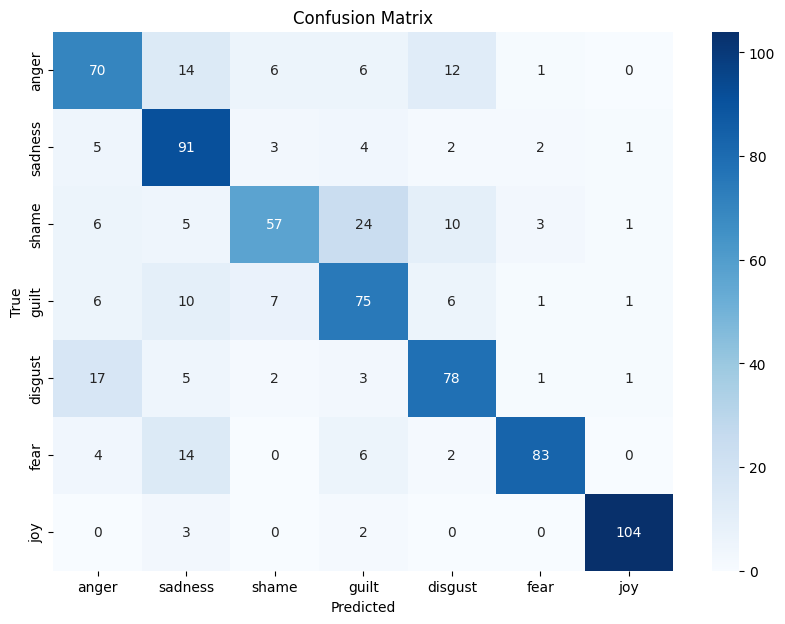

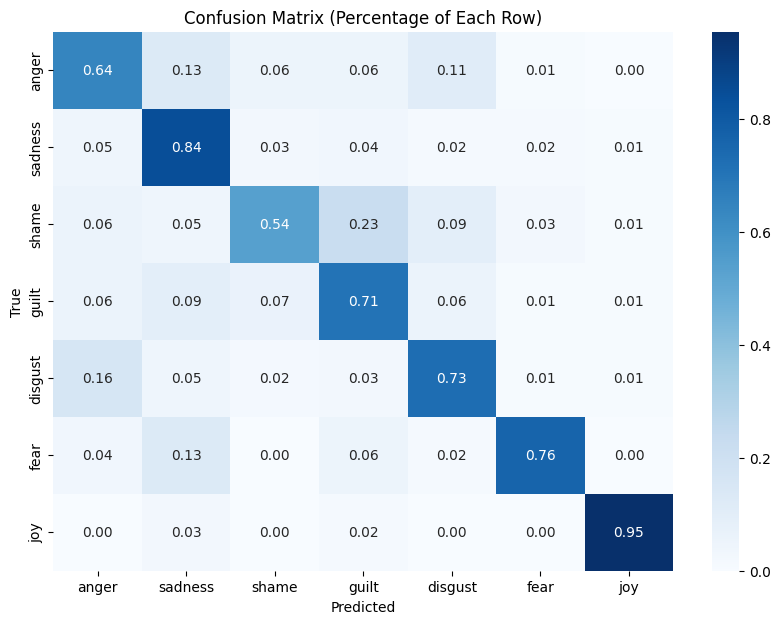

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,claude-3-haiku-20240307,Transfer Learning,0.660477,0.703567,0.659056,0.657013
0,claude-3-sonnet-20240229,Transfer Learning,0.740053,0.751162,0.739235,0.739162


In [58]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": MODEL,
        "Method": "Transfer Learning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)


# Step 2: Confusion matrix
conf_matrix = confusion_matrix(
    df_test["emotion"],
    df_test["predicted_emotion"],
    labels=df_test["emotion"].unique(),
)

# Convert confusion matrix to DataFrame for better plotting
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=df_test["emotion"].unique(),
    columns=df_test["emotion"].unique(),
)

# Step 3: Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Step 1: Compute confusion matrix
conf_matrix = confusion_matrix(
    df_test["emotion"],
    df_test["predicted_emotion"],
    labels=df_test["emotion"].unique(),
)

# Step 2: Normalize the confusion matrix row-wise (i.e., as percentages)
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Step 3: Convert the normalized confusion matrix to a DataFrame for plotting
conf_matrix_normalized_df = pd.DataFrame(
    conf_matrix_normalized,
    index=df_test["emotion"].unique(),
    columns=df_test["emotion"].unique(),
)

# Step 4: Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix (Percentage of Each Row)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


results_df = pd.concat([results_df_tl, results_df])

results_df

## `claude-3-5-sonnet-20240620` Model

In [59]:
# System message defining the role and task for the model
system_message = """
You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
[shame, sadness, joy, guilt, fear, disgust, anger].

**Important Rules:**
1. You must return only **one** of the emotions from the list without additional text.
2. Do **not** create or infer any emotions outside the list.
3. If the text does not match any emotion exactly, return the closest emotion from the list. 
4. Do **not** return 'None', 'jealousy', or any other emotion that is not in the list.
5. Do not return additional text, only **exactly one emotion** of the list.

Your answer can only be shame, sadness, joy, guilt, fear, disgust, or anger.
If you're unsure, assign the closest emotion from the allowed list.


For example:

Text: when the week for exams came I got afraid as to how I would tackle the questions.
Response: fear
"""

MODEL = "claude-3-5-sonnet-20240620"


# Function to create the user message (prompt) for emotion detection
def create_user_message(row):
    return f"{row['text']}"


# Initialize an empty column to store the predictions
df_test["predicted_emotion"] = (
    None  # Create a new column for storing the predicted emotions
)

# Iterate over each row in df_test
for index, row in df_test.iterrows():
    test_messages = []
    user_message = create_user_message(row)
    test_messages.append({"role": "user", "content": user_message})

    # Call the Claude model for emotion classification with the system parameter
    response = client.messages.create(
        model=MODEL,
        max_tokens=7,
        temperature=0,
        system=system_message,  # Correctly passing the system message
        messages=test_messages,  # Using the user input as the main prompt
    )

    # Extract the model's response (predicted emotion)
    predicted_emotion = response.content[0].text.strip()

    # Store the predicted emotion in the new column
    df_test.at[index, "predicted_emotion"] = predicted_emotion

# Display the dataframe with the predicted emotions
df_test.head()

,text,emotion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,anger
1,when i felt powerless to help the poor or when...,sadness,sadness
2,one of my best friends'fianct broke off the re...,shame,shame
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


Classification Report:
              precision    recall  f1-score   support

       anger       0.73      0.56      0.64       109
     sadness       0.85      0.68      0.76       107
       shame       0.91      0.85      0.88       109
       guilt       0.72      0.75      0.73       106
     disgust       0.96      0.99      0.98       109
        fear       0.69      0.85      0.76       108
         joy       0.57      0.69      0.62       106

    accuracy                           0.77       754
   macro avg       0.78      0.77      0.77       754
weighted avg       0.78      0.77      0.77       754



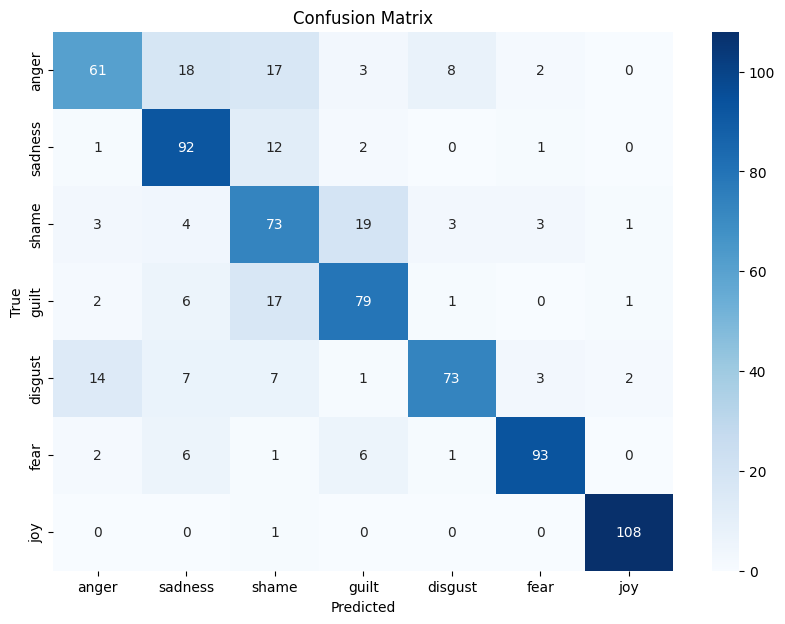

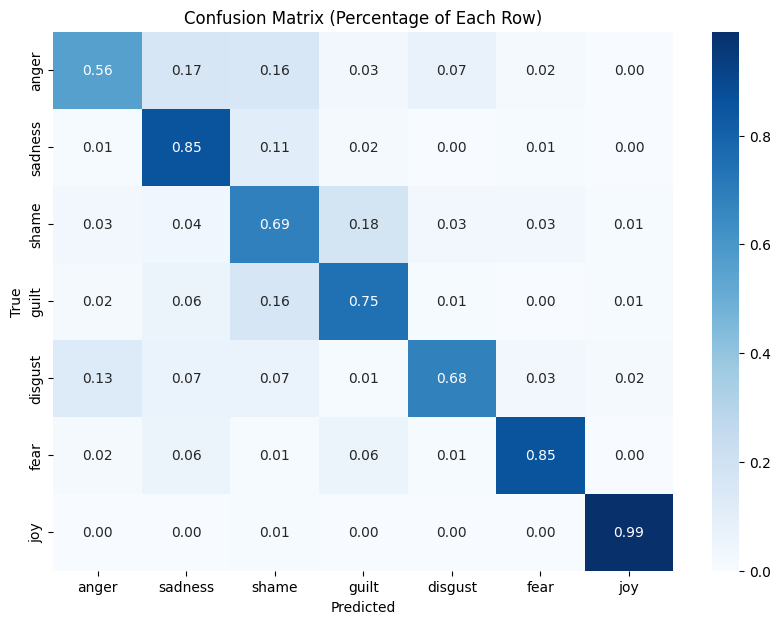

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,claude-3-5-sonnet-20240620,Transfer Learning,0.767905,0.777150,0.767390,0.767098
0,claude-3-haiku-20240307,Transfer Learning,0.660477,0.703567,0.659056,0.657013
0,claude-3-sonnet-20240229,Transfer Learning,0.740053,0.751162,0.739235,0.739162


In [66]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": MODEL,
        "Method": "Transfer Learning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df_tl_3_5 = pd.DataFrame(results)


# Step 2: Confusion matrix
conf_matrix = confusion_matrix(
    df_test["emotion"],
    df_test["predicted_emotion"],
    labels=df_test["emotion"].unique(),
)

# Convert confusion matrix to DataFrame for better plotting
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=df_test["emotion"].unique(),
    columns=df_test["emotion"].unique(),
)

# Step 3: Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Step 1: Compute confusion matrix
conf_matrix = confusion_matrix(
    df_test["emotion"],
    df_test["predicted_emotion"],
    labels=df_test["emotion"].unique(),
)

# Step 2: Normalize the confusion matrix row-wise (i.e., as percentages)
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Step 3: Convert the normalized confusion matrix to a DataFrame for plotting
conf_matrix_normalized_df = pd.DataFrame(
    conf_matrix_normalized,
    index=df_test["emotion"].unique(),
    columns=df_test["emotion"].unique(),
)

# Step 4: Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix (Percentage of Each Row)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


results_df = pd.concat([results_df_tl_3_5, results_df])

results_df

## `claude-3-opus-20240229` Model (More expensive model)

In [67]:
# System message defining the role and task for the model
system_message = """
You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
[shame, sadness, joy, guilt, fear, disgust, anger].

**Important Rules:**
1. You must return only **one** of the emotions from the list without additional text.
2. Do **not** create or infer any emotions outside the list.
3. If the text does not match any emotion exactly, return the closest emotion from the list. 
4. Do **not** return 'None', 'jealousy', or any other emotion that is not in the list.
5. Do not return additional text, only **exactly one emotion** of the list.

Your answer can only be shame, sadness, joy, guilt, fear, disgust, or anger.
If you're unsure, assign the closest emotion from the allowed list.


For example:

Text: when the week for exams came I got afraid as to how I would tackle the questions.
Response: fear
"""

MODEL = "claude-3-opus-20240229"


# Function to create the user message (prompt) for emotion detection
def create_user_message(row):
    return f"{row['text']}"


# Initialize an empty column to store the predictions
df_test["predicted_emotion"] = (
    None  # Create a new column for storing the predicted emotions
)

# Iterate over each row in df_test
for index, row in df_test.iterrows():
    test_messages = []
    user_message = create_user_message(row)
    test_messages.append({"role": "user", "content": user_message})

    # Call the Claude model for emotion classification with the system parameter
    response = client.messages.create(
        model=MODEL,
        max_tokens=7,
        temperature=0,
        system=system_message,  # Correctly passing the system message
        messages=test_messages,  # Using the user input as the main prompt
    )

    # Extract the model's response (predicted emotion)
    predicted_emotion = response.content[0].text.strip()

    # Store the predicted emotion in the new column
    df_test.at[index, "predicted_emotion"] = predicted_emotion

# Display the dataframe with the predicted emotions
df_test.head()

,text,emotion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,anger
1,when i felt powerless to help the poor or when...,sadness,sadness
2,one of my best friends'fianct broke off the re...,shame,guilt
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


Classification Report:
              precision    recall  f1-score   support

       anger       0.82      0.49      0.61       109
     sadness       0.80      0.64      0.71       107
       shame       0.80      0.92      0.85       109
       guilt       0.62      0.81      0.70       106
     disgust       0.96      0.99      0.97       109
        fear       0.62      0.94      0.75       108
         joy       0.80      0.50      0.62       106

    accuracy                           0.75       754
   macro avg       0.77      0.75      0.74       754
weighted avg       0.78      0.75      0.75       754



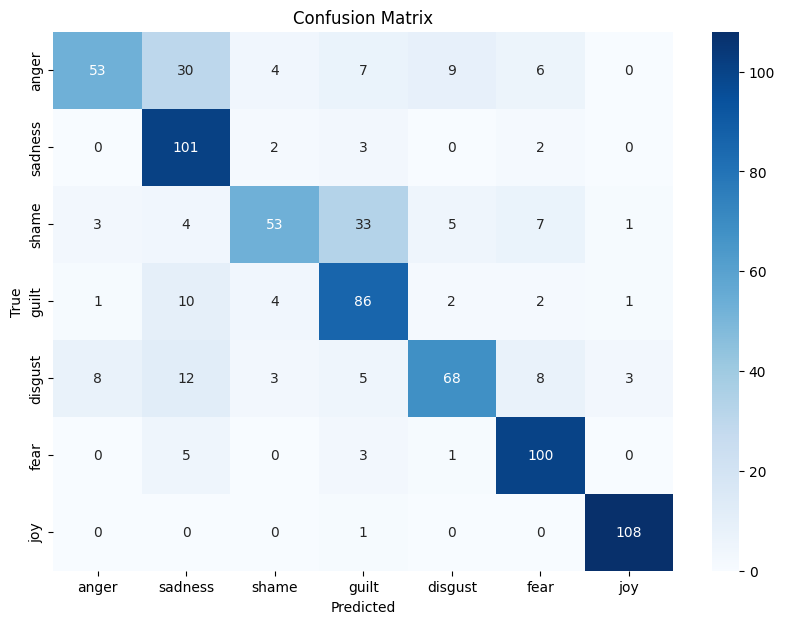

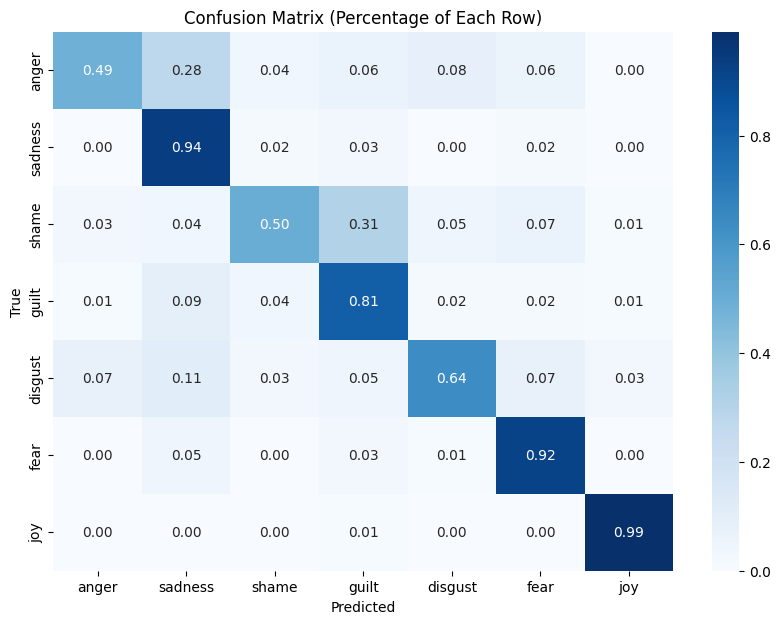

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,claude-3-opus-20240229,Transfer Learning,0.754642,0.774402,0.753788,0.744935
0,claude-3-5-sonnet-20240620,Transfer Learning,0.767905,0.777150,0.767390,0.767098
0,claude-3-haiku-20240307,Transfer Learning,0.660477,0.703567,0.659056,0.657013
0,claude-3-sonnet-20240229,Transfer Learning,0.740053,0.751162,0.739235,0.739162


In [68]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": MODEL,
        "Method": "Transfer Learning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df_tl_opus = pd.DataFrame(results)


# Step 2: Confusion matrix
conf_matrix = confusion_matrix(
    df_test["emotion"],
    df_test["predicted_emotion"],
    labels=df_test["emotion"].unique(),
)

# Convert confusion matrix to DataFrame for better plotting
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=df_test["emotion"].unique(),
    columns=df_test["emotion"].unique(),
)

# Step 3: Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Step 1: Compute confusion matrix
conf_matrix = confusion_matrix(
    df_test["emotion"],
    df_test["predicted_emotion"],
    labels=df_test["emotion"].unique(),
)

# Step 2: Normalize the confusion matrix row-wise (i.e., as percentages)
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Step 3: Convert the normalized confusion matrix to a DataFrame for plotting
conf_matrix_normalized_df = pd.DataFrame(
    conf_matrix_normalized,
    index=df_test["emotion"].unique(),
    columns=df_test["emotion"].unique(),
)

# Step 4: Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix (Percentage of Each Row)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


results_df = pd.concat([results_df_tl_opus, results_df])

results_df

In [70]:
results_df.to_excel("../data/model_results/llm_claude_tl.xlsx", index=False)

## Costos del proceso

A continuación se detallan los costos económicos y el tiempo de computo requeridos por cada modelo para realizar Tranfer Learning sobre el conjunto de prueba (754 registros) utilizando la misma máquina y la misma red.

In [69]:
model_1 = "claude-3-haiku-20240307"
tiempo_1 = "14m 32s"
costo_1 = "0.0615"

model_2 = "claude-3-sonnet-20240229"
tiempo_2 = "14m 29s"
costo_2 = "0.712"

model_3 = "claude-3-5-sonnet-20240620"
tiempo_3 = "14m 11s"
costo_3 = "0.669"

model_4 = "claude-3-opus-20240229"
tiempo_4 = "35m 23s"
costo_4 = "3.34"

# Create the dataframe
data = {
    "model": [model_1, model_2, model_3, model_4],
    "tiempo": [tiempo_1, tiempo_2, tiempo_3, tiempo_4],
    "costo": [costo_1, costo_2, costo_3, costo_4],
}

df_models = pd.DataFrame(data)

# Display the dataframe
df_models

,model,tiempo,costo
0,claude-3-haiku-20240307,14m 32s,0.0615
1,claude-3-sonnet-20240229,14m 29s,0.712
2,claude-3-5-sonnet-20240620,14m 11s,0.669
3,claude-3-opus-20240229,35m 23s,3.34


In [71]:
df_models.to_excel("../data/model_results/costo_llm_claude_tl.xlsx", index=False)